# 01_OPERA_phase_unwrap

Here, we introduce the concept of Interferometric Synthetic Aperture Radar (InSAR) and the difficulties in measuring accurate phase differences. In our case, we want these phase differences to act as an estimation for snow water equivalent but this notebook is more of an overview of what exactly phase differences are and how they're present in our data

Please reference the holy grail (OPERA CSLC metadata) for more information:

https://d2pn8kiwq2w21t.cloudfront.net/documents/OPERA_CSLC-S1_ProductSpec_v1.0.0_D-108278_Initial_2023-09-11_URS321269.pdf

In [1]:
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
from shapely.geometry import box
import numpy as np
import pandas as pd
from subprocess import call
import h5py
import matplotlib.pyplot as plt
import subprocess

### What is InSAR?

**Interferometric Synthetic Aperture Radar (InSAR)** is a remote sensing technique that commonly measures surface displacement by analyzing the phase difference between two radar images of the same area. These images are collected at different times using radar sensors on satellites. The fundamental idea behind InSAR is that the phase difference between corresponding pixels in two SAR images contains information about the movement of the Earth's surface in the line-of-sight direction of the radar sensor.

![InSAR Diagram](../images/insar_diagram.jpg)

The process begins with the acquisition of two radar images, commonly referred to as a "master" and "slave" images (but let's refer to them as a "source" image and a "second" image for obvious reasons), taken from essentially the same position in a satellite's orbit at different times. These images are compared to generate an **interferogram**, which captures the phase differences between the two radar signals. When the radar waves are reflected back to the sensor, they carry information about the distance between the satellite and the surface below. 

**Phase** refers to the position of a wave in its cycle. In the context of radar, it describes the relative position of the radar signal when it reaches the satellite's sensor. The **phase difference** between the signals from the two images measures the change in distance between the satellite and the surface - think of it as a measure of distance. When we talk about **wrapped phase**, we mean that the phase difference is confined to a specific range, usually between -π and π, due to the periodic nature of the radar signal. If the phase difference exceeds this range, it "wraps around" to stay within -π to π, causing the values to reset. This is called "wrapped" phase and how our data is stored:

$$
\varphi = W \left( \varphi_{\text{topography}} + \varphi_{\text{deformation}} + \varphi_{\text{atmosphere}} + \varphi_{\text{orbit}} + \varphi_{\text{noise}} \right)
$$

Where:
- $\varphi_{\text{topography}}$ represents the phase due to surface topography.
- $\varphi_{\text{deformation}}$ accounts for phase changes due to surface displacement.
- $\varphi_{\text{atmosphere}}$ includes phase shifts caused by atmospheric effects.
- $\varphi_{\text{orbit}}$ represents errors from satellite orbit inaccuracies.
- $\varphi_{\text{noise}}$ includes phase shifts from random noise.
- $W$ is the wrap operator that bounds the total phase between -π and π.

We want to isolate $\varphi_{\text{deformation}}$ as best as possible so we can get an accurate estimation of the "true" change in distance between the sensor and the surface between each acquisition. Luckily for us, NASA OPERA products are slay and the CSLC products we're using are rigorously corrected for each variable. In general, though, $\varphi_{\text{topography}}$ and $\varphi_{\text{atmosphere}}$ typically have the biggest influence in terms of error, whereas $\varphi_{\text{orbit}}$ and $\varphi_{\text{noise}}$ are more negligible.

TODO: provide references for tropospheric and topographic errors

In **InSAR**, the phase difference we're working towards by isolating $\varphi_{\text{deformation}}$ directly corresponds to **surface displacement**. This displacement, particularly in the **line-of-sight** direction of the sensor, is encoded in the wrapped phase. By **unwrapping** the phase, we can obtain continuous measurements of surface motion over a region, which is essential for monitoring phenomena such as **earthquakes**, **land subsidence**, and  **snow water equivalent** in our case. Unwrapping involves converting the wrapped phase (with values between -π and π) into a continuous map that reflects the true displacement, but more on that later in this notebook.

> [!NOTE]  
> Coregistration, the process of aligning two radar images so that they match perfectly in space, is a crucial step in InSAR. However, NASA's OPERA CSLC products have already undergone this process, so we will skip this step. For more information on coregistration and its importance, check out this https://earth.esa.int/eogateway/documents/20142/37627/Coregistration_Small_Baseline_InSAR_image_subsets_pointwise_targets.pdf

In [4]:
%%time
# load in our wrapped phase data from 00_SAR_intro.ipynb
fn_1 = "/home/jehayes/sh_final/cslc/asc/OPERA_L2_CSLC-S1_T049-103322-IW2_20180103T010924Z_20240428T014600Z_S1B_VV_v1.1.h5"
fn_2 = "/home/jehayes/sh_final/cslc/asc/OPERA_L2_CSLC-S1_T049-103322-IW2_20180115T010923Z_20240428T051456Z_S1B_VV_v1.1.h5"

dsR = xr.open_dataset(fn_1,
                      group='data',
                      engine='h5netcdf')['VV'].rename(dict(x_coordinates='x', y_coordinates='y'))
tR = pd.to_datetime(xr.open_dataset(fn_1, 
                                    group='identification')['zero_doppler_start_time'].data.astype('U')) # Unicode string format
dsS = xr.open_dataset(fn_2,
                      group='data',
                      engine='h5netcdf')['VV'].rename(dict(x_coordinates='x', y_coordinates='y'))

tS = pd.to_datetime(xr.open_dataset(fn_2, group='identification')['zero_doppler_start_time'].data.astype('U'))

ifg = dsR * np.conj(dsS)
ifg.attrs['reference'] = tR
ifg.attrs['secondary'] = tS
da = xr.apply_ufunc(np.angle, ifg)
# this 'phase' variable is our $$\varphi$$ seen above (the wrapped phase)
ds = da.to_dataset(name='phase')
ds.rio.write_crs('EPSG:32613', inplace=True)

CPU times: user 11.2 s, sys: 2.06 s, total: 13.3 s
Wall time: 13.9 s


<xarray.Dataset> Size: 409MB
Dimensions:      (x: 20670, y: 4941)
Coordinates:
  * x            (x) float64 165kB 7.14e+05 7.14e+05 ... 8.173e+05 8.173e+05
  * y            (y) float64 40kB 4.218e+06 4.218e+06 ... 4.169e+06 4.169e+06
    spatial_ref  int64 8B 0
Data variables:
    phase        (y, x) float32 409MB nan nan nan nan nan ... nan nan nan nan

##### Topographic Phase and Its Removal

When generating an InSAR interferogram, one of the key contributors to the observed phase difference is the **topography** of the surface being observed. $\varphi_{\text{topography}}$ arises due to the variation in the elevation of the surface, which causes different radar signal paths to have different lengths. In simple terms, higher elevations increase the distance between the radar and the surface, while lower elevations reduce it. These differences create phase shifts that are purely due to topographical features, not due to any deformation or displacement of the surface.

The topographic phase is a common artifact in InSAR measurements because it distorts the true surface displacement signal. Without removing it, we would not be able to distinguish between actual displacement (such as due to land subsidence or earthquakes) and phase shifts that are simply caused by changes in surface elevation.

To isolate the true deformation signal, we need to **subtract the topographic phase**. This is typically done by using a reference Digital Elevation Model (DEM). The DEM provides a detailed map of the surface elevation and allows us to calculate the phase contribution due to topography at each point in the radar image. Once this topographic phase is modeled, it can be subtracted from the interferogram, leaving us with a phase signal that better represents the surface displacement (plus any residual errors, such as atmospheric phase shifts or noise).

The process works as follows:

1. **Generate the topographic phase**: Using the reference DEM, calculate the expected phase shift at each pixel based on the elevation.
$$ 
\varphi_{\text{topography}} = \frac{4\pi B h}{λ R \sin(\theta)} 
$$
- **$\lambda$**: Wavelength of the radar signal (in meters).
- **$4\pi$**: Constant factor used in the formula for calculating the topographic phase.
- **$h$**: Elevation of the surface from the Digital Elevation Model (DEM) (in meters).
- **$R$**: Radar line-of-sight distance from the sensor to the surface (in meters).
- **$\theta$**: Incidence angle of the radar signal (in radians).
2. **Subtract the topographic phase**: Remove the calculated topographic phase from the interferogram, which leaves a phase signal primarily due to displacement.

In our case, our reference DEM is the Copernicus 30 GLO-DEM at 30m spatial resolution and the topographic "flattening" is already done for us because the OPERA CSLC products are awesome. We just have to pull out this corrected phase from the metadata

This is done before unwrapping our phase since $\varphi_{\text{topography}}$ is itself a phase term expressed in radians and thus behaves the same way as the wrapped phase.

In [5]:
# get topographically corrected flattening phase from both acquisitions
with h5py.File(fn_1, 'r') as f:
    flat_phase1 = f['data/flattening_phase'][()]
with h5py.File(fn_2, 'r') as f:
    flat_phase2 = f['data/flattening_phase'][()]
diff_flat_phase = flat_phase2 - flat_phase1

In [6]:
# Convert to xarray with same coordinates as original dataset
diff_flat_phase_da = xr.DataArray(
    diff_flat_phase,
    dims=['y', 'x'],
    coords={'y': ds.y, 'x': ds.x}
)

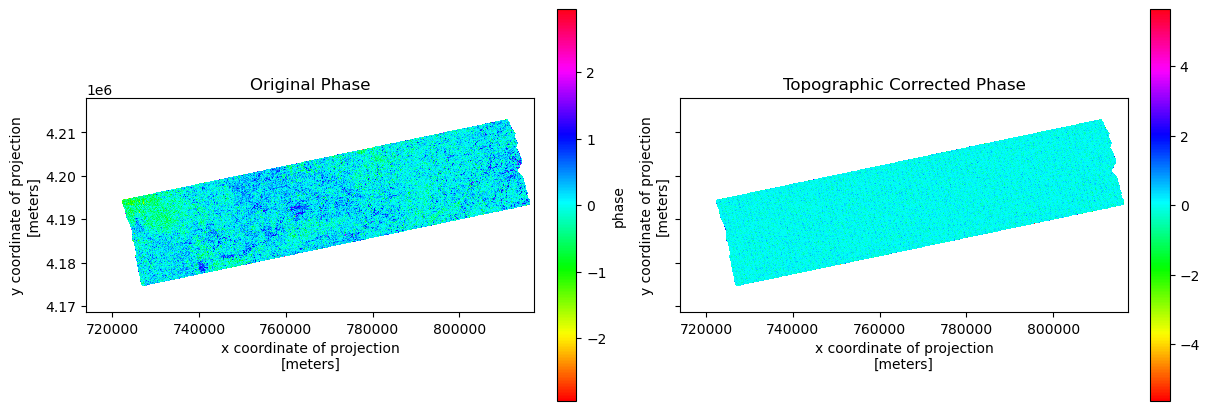

In [7]:
# plot with coarsening for quicker plots
nx = 16
ny = 8
f, axs = plt.subplots(1,2,figsize=(12,4), constrained_layout=True,
                      sharex=True, sharey=True)
ds.phase.coarsen(x=nx,y=ny, boundary='trim').mean().plot.imshow(cmap='hsv', ax=axs[0])
axs[0].set_title('Original Phase')
diff_flat_phase_da.coarsen(x=nx, y=ny, boundary='trim').mean().plot.imshow(cmap='hsv', ax=axs[1])
axs[1].set_title('Topographic Corrected Phase')

axs[0].set_aspect('equal')
axs[1].set_aspect('equal')
plt.show()

> [!NOTE]  
> The original phase from returns values in the range [-π, π] because this is the principal value range for the arctangent function used to compute phase from complex numbers. The differential flattening phase spans [-2π, 2π] because it represents the difference between two phase measurements, which doubles the potential range of values.

> We also see that our topographic corrected phase has values close to 0. This is good and expected as you will see in the phase unwrapping section

##### Atmospheric Phase and Its Correction  

Another significant source of error in InSAR measurements is the **atmospheric phase delay** ($\varphi_{\text{atmosphere}}$). Atmospheric conditions, such as variations in temperature, pressure, and water vapor content, can affect the propagation of radar waves, introducing phase delays that are unrelated to surface displacement. These effects are particularly noticeable in regions with strong weather variability or significant topographic relief.  

Correcting for atmospheric phase delays is essential to obtain accurate deformation measurements. The process typically involves estimating the atmospheric contribution and subtracting it from the interferogram. This can be done using:  

1. **Empirical models**: Statistical methods based on external weather data or empirical corrections derived from multiple interferograms.  
2. **Numerical weather models**: High-resolution weather models, such as the ECMWF ERA5 or NASA's MERRA-2, can provide estimates of atmospheric delays at the time of radar acquisitions.  
3. **GPS and other auxiliary data**: Ground-based GPS stations and other remote sensing data (e.g., MODIS water vapor maps) can help refine atmospheric corrections.  

In practice, many modern InSAR products, including NASA OPERA CSLC datasets, come with pre-applied atmospheric corrections as we'll see below. However, residual atmospheric effects may still be present, particularly in challenging environments. For further details on atmospheric correction techniques, refer to **Ferretti et al. (2001)** and **Jolivet et al. (2014)**.

In [8]:
# Check reference image corrections
with h5py.File(fn_1, 'r') as f:
    dry_trop_ref = f['metadata/processing_information/parameters/dry_troposphere_weather_model_applied'][()]
    wet_trop_ref = f['metadata/processing_information/parameters/wet_troposphere_weather_model_applied'][()]
    static_trop_ref = f['metadata/processing_information/parameters/static_troposphere_applied'][()]
    print(f"Reference image corrections:")
    print(f"Dry troposphere: {dry_trop_ref}")
    print(f"Wet troposphere: {wet_trop_ref}") 
    print(f"Static troposphere: {static_trop_ref}")
# Check secondary image corrections
with h5py.File(fn_2, 'r') as f:
    dry_trop_sec = f['metadata/processing_information/parameters/dry_troposphere_weather_model_applied'][()]
    wet_trop_sec = f['metadata/processing_information/parameters/wet_troposphere_weather_model_applied'][()]
    static_trop_sec = f['metadata/processing_information/parameters/static_troposphere_applied'][()]
    print(f"\nSecondary image corrections:")
    print(f"Dry troposphere: {dry_trop_sec}")
    print(f"Wet troposphere: {wet_trop_sec}")
    print(f"Static troposphere: {static_trop_sec}")

Reference image corrections:
Dry troposphere: False
Wet troposphere: False
Static troposphere: True

Secondary image corrections:
Dry troposphere: False
Wet troposphere: False
Static troposphere: True


We see above that 'static troposphere' corrections were applied to both radar images. More on this in the OPERA CSLC metadata hyperlinked at the top of the notebook

##### Phase from Orbit and Its Impact

In InSAR measurements, another potential source of error is the **orbital phase** ($\varphi_{\text{orbit}}$), which arises due to the uncertainty in the satellite's position and motion during radar acquisition (as we have to know where the satellite is during both acquisitions to accurately calculate distance). The phase from orbit reflects differences in the satellite's actual position compared to its assumed position at the time of data acquisition, leading to small phase shifts in the interferogram. 

Orbital data can be divided into two types:

1. **Restituted orbits**: Quick, less accurate orbital data available shortly after acquisition, typically used for early processing and analysis. These orbits are computed from available tracking data but may contain small inaccuracies.
2. **Precise orbits**: Highly accurate orbital data available after several days or weeks, derived from more extensive tracking information and corrections. These orbits provide a much more accurate satellite position and are used for final, precise interferogram processing.

In most cases, errors due to orbital phase differences are negligible. The contribution of the phase from orbit is small compared to other sources of phase error, such as topographic or atmospheric effects. As a result, while orbital data accuracy is important, it typically does not significantly impact the final deformation measurements.

In [9]:
with h5py.File(fn_1, 'r') as f:
    orbit_type = f['metadata/orbit/orbit_type'][()]
    print(f"Reference image orbit type: {orbit_type}")

with h5py.File(fn_2, 'r') as f:
    orbit_type = f['metadata/orbit/orbit_type'][()]
    print(f"Secondary image orbit type: {orbit_type}")

Reference image orbit type: b'POEORB'
Secondary image orbit type: b'POEORB'


We see above that both radar images have precise orbits, minimizing the respective errors

##### Phase from Noise

Another source of error in InSAR measurements is **random noise** ($\varphi_{\text{noise}}$), which arises due to inherent sensor limitations, environmental factors, and other unpredictable influences during data acquisition. This noise introduces random phase variations that do not correspond to actual surface displacement.

However, the effect of random noise is typically negligible in well-processed interferograms, as noise tends to average out across multiple acquisitions or through appropriate filtering, leaving the true deformation signal intact.

In [10]:
with h5py.File(fn_1, 'r') as f:
    noise_files = f['metadata/processing_information/inputs/noise_files'][()]
    print(f"Reference image noise files:")
    print(noise_files)

with h5py.File(fn_2, 'r') as f:
    noise_files = f['metadata/processing_information/inputs/noise_files'][()]
    print(f"\nSecondary image noise files:")
    print(noise_files)

Reference image noise files:
b'noise-s1b-iw2-slc-vv-20180103t010859-20180103t010927-009000-010123-005.xml'

Secondary image noise files:
b'noise-s1b-iw2-slc-vv-20180115t010858-20180115t010926-009175-0106d2-005.xml'


And we see above the path to metadata files concerning noise corrections applied to each radar image. There are ways to quantify the phase error due to random noise, but that doesn't fit within the scope of this final project so we'll leave it at that

##### How do we Unwrap the Phase?

To actually get an interpretable deformation measurement, we neep to 'unwrap' the phase to obtain a continuous phase map. This involves integrating the phase differences between neighboring pixels. The unwrapped phase φ_unwrapped at a pixel (i, j) is given by:

$$
φ_{\text{unwrapped}}(i, j) = φ_{\text{wrapped}}(i, j) + 2π \sum_{k=1}^{i} \sum_{l=1}^{j} Δφ(k, l)
$$
https://hyp3-docs.asf.alaska.edu/guides/insar_product_guide

where Δφ(k, l) is the phase difference between neighboring pixels. Various algorithms, such as the Minimum Cost Flow method, are employed to perform phase unwrapping, aiming to minimize the total phase difference across the entire image.
https://www.gamma-rs.ch/uploads/media/2002-4_PhaseUnwrapping.pdf

This process is challenging, though, and many factors can affect the quality of the unwrapped phase map. For instance, noise, phase discontinuities (when phase differences are very large, the algorithm might mistakenly treat it as a jump of 2π), and path dependence (the sequence of pixels or data points traversed during the unwrapping process - the summation over neighboring pixels (k, l) can produce different results if the order or direction of integration changes) can all impact the accuracy of the unwrapping process.
https://igppweb.ucsd.edu/~fialko/insar/phase_unwrap.pdf
https://arxiv.org/abs/1806.01832

In [ ]:
# TODO: add more documentation for ISCE and typical softwares used and why it's different with OPERA
# still learning this...

##### FFT‑Based Least‑Squares Phase Unwrapping via the Poisson Equation

To obtain an interpretable deformation measurement from interferometric SAR data, we need to convert the wrapped phase which is ambiguous modulo 2 $\pi$ into a continuous phase map. One common approach is to solve the Poisson equation, which can be written as:

$$
\nabla^2 \phi_{\text{unwrapped}} = \text{div}(\Delta\phi),
$$

where:
- $\phi_{\text{unwrapped}}$ is the continuous, unwrapped phase,
- $\Delta\phi$ represents the finite differences (phase gradients) between neighboring pixels.

In this context, the unwrapped phase at a pixel \( (i,j) \) can be conceptually obtained by integrating the phase differences:

$$
\phi_{\text{unwrapped}}(i,j) = \phi_{\text{wrapped}}(i,j) + 2\pi \sum_{k=1}^{i} \sum_{l=1}^{j} \Delta\phi(k,l)
$$

Our custom function `unwrap_phase_fft` implements this FFT‑based least‑squares method. It calculates the finite differences along the horizontal (x) and vertical (y) directions to estimate the phase gradients, computes their divergence, and then solves the Poisson equation in the Fourier domain using an FFT-based solver. This approach is analogous in spirit to the WDCT‑LS method used in ISCE2 but is implemented here as a lightweight, standalone function that operates directly on NumPy arrays and integrates seamlessly with xarray DataArrays.

We choose this method over using the full ISCE/ISCE2 software because it allows for a simplified, efficient, and Python‑native workflow when processing NASA OPERA CSLC products in Xarray data formats, without the additional complexity and dependencies of the complete ISCE processing chain.

This is all quite dense, and hard to fit into a notebook let alone one markdown cell, so here are some additional resources:

- **Phase Unwrapping Process**: For a comprehensive overview of phase unwrapping techniques, including the least-squares approach, you can refer to this detailed document: [Phase Unwrapping Overview](https://igppweb.ucsd.edu/~fialko/insar/phase_unwrap.pdf)

- **Poisson Equation**: The Poisson equation is fundamental in various fields, including physics and engineering. A robust phase unwrapping algorithm that utilizes the Poisson equation is discussed in this paper: [Robust Phase Unwrapping Algorithm](https://opg.optica.org/abstract.cfm?uri=oe-29-15-24466)

- **Fast Fourier Transforms (FFTs)**: FFTs are essential for efficiently solving the Poisson equation in the frequency domain. A fast and accurate phase-unwrapping algorithm based on the FFT is presented in this study: [FFT-Based Phase Unwrapping Algorithm](https://opg.optica.org/ao/upcoming_pdf.cfm?id=296032)

- **ISCE GitHub Repository**: The InSAR Scientific Computing Environment (ISCE) is an open-source library for processing Interferometric Synthetic Aperture Radar (InSAR) data. You can explore its features and access the code here: [ISCE GitHub Repository](https://github.com/isce-framework/isce2)

In [ ]:
# option to coarsen, but we won't
nx = 1
ny = 1
wrapped_phase_da = diff_flat_phase_da.coarsen(x=nx, y=ny, boundary='trim').mean()

In [ ]:
def unwrap_phase_fft(wrapped):
    """
    Unwrap a 2D wrapped phase image using an FFT-based least-squares approach.
    
    The unwrapped phase φ_unwrapped at a pixel (i, j) can be thought
    of as the sum of the wrapped phase φ_wrapped at (i, j) plus an integer multiple of 2π that
    accounts for the cumulative phase differences (Δφ) between neighboring pixels:
    
       φ_unwrapped(i, j) = φ_wrapped(i, j) + 2π ∑ₖ₌₁ⁱ ∑ₗ₌₁ʲ Δφ(k, l)
    
    This function uses finite differences to compute the phase gradients (i.e. the phase differences 
    between neighboring pixels along the horizontal (x) and vertical (y) directions), constructs 
    the divergence of these differences, and then solves a Poisson equation using FFTs to recover 
    the unwrapped phase.

    The foundation for our FFT‑based least‑squares unwrapping function is conceptually based on the WDCT‑LS 
    (Weighted Discrete Cosine Transform Least‑Squares) method implemented in ISCE2. 
    In ISCE2, a similar approach is used to solve the Poisson equation for phase unwrapping, 
    integrating the finite differences (phase gradients) to obtain a continuous phase field.
    https://github.com/isce-framework/isce2/blob/main/contrib/UnwrapComp/phaseUnwrap.py
    Our function adapts this conceptual approach (computing finite differences, building the divergence, and solving via FFT) 
    in a simplified, standalone version for use directly on NumPy arrays and xarray DataArrays.
    
    Parameters
    ----------
    wrapped : 2D numpy array
        Wrapped phase in radians (ideally in the interval [-π, π], although your data might span 
        a slightly different range, e.g. [-2π, 2π]). The array may contain NaNs.
        
    Returns
    -------
    unwrapped : 2D numpy array
        Unwrapped phase in radians. This continuous phase field can then be converted to physical 
        displacement (e.g., using d = unwrapped_phase * (λ / (4π)) for a repeat-pass interferogram).
    """
    # -------------------------------------------------------------------------
    # 1. Ensure no NaNs are present.
    # NaNs will disrupt arithmetic and FFT computations
    # We replace them with the mean of the valid phase values so that the finite difference
    # calculations and the subsequent FFT do not propagate NaNs
    if np.isnan(wrapped).any():
        fill_value = np.nanmean(wrapped)  # get the mean of all valid (non-NaN) values.
        wrapped = np.where(np.isnan(wrapped), fill_value, wrapped)  # replace NaNs.
    
    # Get the dimensions of the input wrapped phase image.
    M, N = wrapped.shape

    # -------------------------------------------------------------------------
    # 2. Compute Finite Differences (Phase Gradients)
    # The finite difference along the horizontal direction (axis=1) computes the difference between
    # adjacent columns, representing the local phase change in the x-direction.
    # Similarly, the finite difference along the vertical direction (axis=0) computes differences
    # between adjacent rows, representing the local phase change in the y-direction.
    # These differences (dx and dy) form the discrete phase gradients that, when integrated,
    # reconstruct the continuous (unwrapped) phase.
    dx = np.diff(wrapped, axis=1)  # horizontal phase difference; shape becomes (M, N-1)
    dy = np.diff(wrapped, axis=0)  # vertical phase difference; shape becomes (M-1, N)

    # NOTE:
    # These finite differences are not the same as line-of-sight (LOS) deformation.
    # Rather, they are the differences in the measured (wrapped) phase between adjacent pixels.
    # LOS deformation is later derived from the unwrapped phase (using a conversion factor).

    # -------------------------------------------------------------------------
    # 3. Wrap the Finite Differences to the Interval [-π, π]
    # When computing differences, the raw subtraction might yield values outside the principal range.
    # The expression np.angle(np.exp(1j * value)) maps any phase difference back into the range [-π, π].
    # Even if your input wrapped phase spans [-2π, 2π], we want the differences to represent the
    # true smallest angular difference between pixels.
    dx = np.angle(np.exp(1j * dx))
    dy = np.angle(np.exp(1j * dy))

    # -------------------------------------------------------------------------
    # 4. Expand the Computed Differences Back to the Full Image Size
    # The np.diff function reduces the dimensions by one (since it computes differences between
    # adjacent pixels). To compute a divergence (which must have the same shape as the original image),
    # we "expand" (pad) these arrays back to size (M, N) by creating arrays of zeros and inserting the
    # computed finite differences into all positions where they are defined.
    # For dx, we fill columns 0 to N-2, leaving the last column as 0.
    # For dy, we fill rows 0 to M-2, leaving the last row as 0.
    dx_full = np.zeros((M, N), dtype=wrapped.dtype)
    dy_full = np.zeros((M, N), dtype=wrapped.dtype)
    dx_full[:, :-1] = dx
    dy_full[:-1, :] = dy

    # -------------------------------------------------------------------------
    # 5. Build the Divergence (Right-Hand Side of the Poisson Equation)
    # The divergence of the phase gradient field is the net "flow" of phase difference out of each pixel.
    # In our discrete formulation, we compute it by taking differences of the finite differences.
    # For the x-component, the divergence at column 0 is simply the first finite difference, and for
    # subsequent columns, it is the difference between adjacent values of dx_full.
    # Similarly for the y-component.
    rhs = np.zeros((M, N), dtype=wrapped.dtype)
    # Compute x divergence:
    rhs[:, 0] = dx_full[:, 0]                   # The first column (no left neighbor exists).
    rhs[:, 1:] = dx_full[:, 1:] - dx_full[:, :-1] # Difference between consecutive horizontal differences.
    # Compute y divergence:
    rhs[0, :] += dy_full[0, :]                  # The first row (no upper neighbor exists).
    rhs[1:, :] += dy_full[1:, :] - dy_full[:-1, :]# Difference between consecutive vertical differences.

    # This divergence corresponds to the accumulated difference between the wrapped phase gradients
    # and what would be the true (unwrapped) phase gradients, integrated over the image.

    # -------------------------------------------------------------------------
    # 6. Solve the Poisson Equation Using FFT
    # The Poisson equation in this context is: ∇² φ_unwrapped = divergence, where the divergence (rhs)\n",
    # represents the difference between the measured (wrapped) gradients and the true gradients.
    # By taking the FFT of both sides, the Laplacian operator becomes a multiplication in the frequency domain.
    fft_rhs = np.fft.fft2(rhs)  # Compute the 2D FFT of the divergence field.
    
    # Generate frequency grids for the two dimensions.
    # np.fft.fftfreq returns frequencies in cycles per pixel, and multiplying by 2π converts to radians.
    x_freq = np.fft.fftfreq(N) * 2 * np.pi
    y_freq = np.fft.fftfreq(M) * 2 * np.pi
    # Create a 2D meshgrid of frequencies; note 'ij' indexing to match array dimensions.
    Y, X = np.meshgrid(y_freq, x_freq, indexing='ij')
    
    # The denominator corresponds to the eigenvalues of the discrete Laplacian operator:
    # For a pixel grid, the Laplacian eigenvalues are: 2*cos(X) + 2*cos(Y) - 4.
    # We rearrange it as: (2*cos(X) - 2) + (2*cos(Y) - 2).
    denom = (2 * np.cos(X) - 2) + (2 * np.cos(Y) - 2)
    # Set the zero-frequency (DC) component to 1 to avoid division by zero.
    # This component represents the overall mean of the solution, which is undetermined
    # We will later set it explicitly to 0 to fix the arbitrary constant in phase
    denom[0, 0] = 1.0
    
    # Divide the FFT of the divergence by the eigenvalue spectrum to get the FFT of the unwrapped phase.
    fft_phi = fft_rhs / denom
    # Set the DC component (mean value) of the unwrapped phase to 0, since absolute phase is ambiguous
    fft_phi[0, 0] = 0.0
    
    # Invert the FFT to transform back to the spatial domain, yielding the unwrapped phase map.
    # The real part is taken because the imaginary part should be negligible (numerical noise).
    unwrapped = np.real(np.fft.ifft2(fft_phi))
    
    # The resulting 'unwrapped' phase is now a continuous field (in radians) that can be used to derive
    # physical displacement measurements (e.g., via d = unwrapped * (λ/(4π)))
    return unwrapped

In [12]:
%%time
# Assume diff_flat_phase_da is your DataArray with wrapped phase.
# (Here, we are not coarsening, so nx=ny=1)
wrapped_phase_da = diff_flat_phase_da.coarsen(x=1, y=1, boundary='trim').mean()
wrapped_phase_np = wrapped_phase_da.values

# Unwrap the phase using our custom function.
unwrapped_np = unwrap_phase_fft(wrapped_phase_np)

# Convert back to an xarray DataArray.
unwrapped_da = xr.DataArray(unwrapped_np, dims=wrapped_phase_da.dims, coords=wrapped_phase_da.coords)
ds_unwrapped = unwrapped_da.to_dataset(name='unwrapped_phase')

CPU times: user 32.1 s, sys: 13.9 s, total: 46 s
Wall time: 47 s


In [ ]:
# mask our unwrapped phase to the same extent as our wrapped pahse
unwrapped_da = unwrapped_da.where(~np.isnan(diff_flat_phase_da))

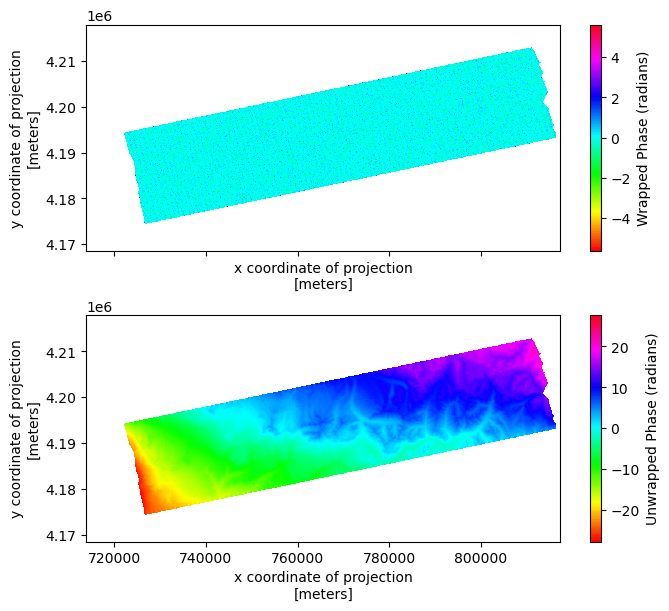

In [24]:
nx = 16
ny = 8
f, axs = plt.subplots(2,1,figsize=(7,6), constrained_layout=True,
                      sharex=True, sharey=True)
axs[0].set_title('Wrapped Phase')
diff_flat_phase_da.coarsen(x=nx, y=ny, boundary='trim').mean().plot.imshow(cmap='hsv', ax=axs[0],
                                                                           cbar_kwargs={'label': 'Wrapped Phase (radians)'})
axs[1].set_title('Unwrapped Phase')
unwrapped_da.coarsen(x=nx, y=ny, boundary='trim').mean().plot.imshow(cmap='hsv', ax=axs[1],
                                                                     cbar_kwargs={'label': 'Unwrapped Phase (radians)'})
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')
plt.show()

In [ ]:
# TODO: why does our unwrapped phase have topographic signals??W

Now we have a solved phase field that we can convert to geophysical quantities

##### Conversion of Unwrapped Phase to Physical Displacement

In repeat‑pass InSAR, the relationship between the unwrapped phase and the line‑of‑sight displacement is given by:

$$
d = \Delta\phi \frac{\lambda}{4\pi},
$$

where:
- $d$ is the displacement in meters,
- $\Delta\phi$ is the unwrapped phase in radians,
- $\lambda$ is the radar wavelength (for Sentinel‑1, $\lambda$ approx 0.055m).

In [26]:
# radar wavelength in meters (Sentinel-1 C-band)
wavelength = 0.055
# Convert the unwrapped phase (in radians) to displacement (in meters)
# d = unwrapped_phase * (wavelength / (4*pi))
displacement_da = unwrapped_da * (wavelength / (4 * np.pi))
ds_displacement = displacement_da.to_dataset(name='displacement')

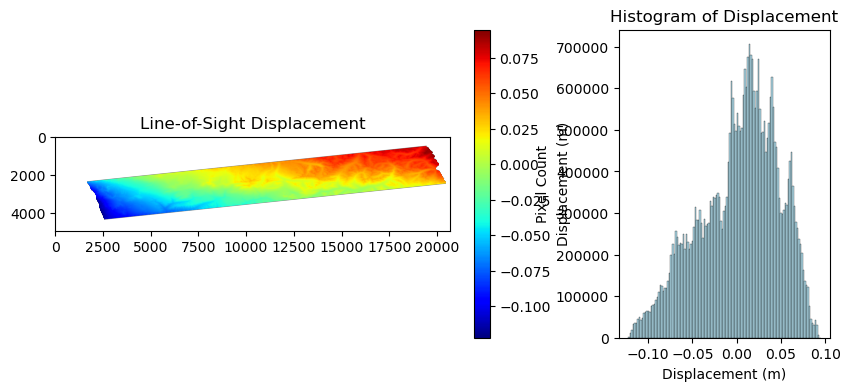

In [35]:
fig = plt.figure(figsize=(10,4))
gs = fig.add_gridspec(1, 2, width_ratios=[7,3])

# displacement map
ax1 = fig.add_subplot(gs[0])
im = ax1.imshow(displacement_da, cmap='jet')
ax1.set_title("Line-of-Sight Displacement")
plt.colorbar(im, ax=ax1, label="Displacement (m)")

# histogram
ax2 = fig.add_subplot(gs[1])
ax2.hist(displacement_da.values.flatten(), bins=128,
         color='lightblue', edgecolor='black', linewidth=0.2)
ax2.set_title("Histogram of Displacement")
ax2.set_xlabel("Displacement (m)")
ax2.set_ylabel("Pixel Count");